In [1]:
%load_ext autoreload
%autoreload 2

import torch
import spe
import numpy as np
import matplotlib.pyplot as plt

<generator object Module.parameters at 0x7fa05b8f2f90>
[4000]
nfft 2000 hop 250


/home/antoine/anaconda3/envs/at/lib/python3.8/site-packages/torch/functional.py:515: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729002806/work/aten/src/ATen/native/SpectralOps.cpp:590.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore
/home/antoine/anaconda3/envs/at/lib/python3.8/site-packages/torch/functional.py:586: UserWarning: The function torch.irfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.irfft. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729002806/work/aten/src/ATen/native/SpectralOps.cpp:602.)
  return _VF.istft(input, n_fft, hop_length, win_length, window, center,  # typ

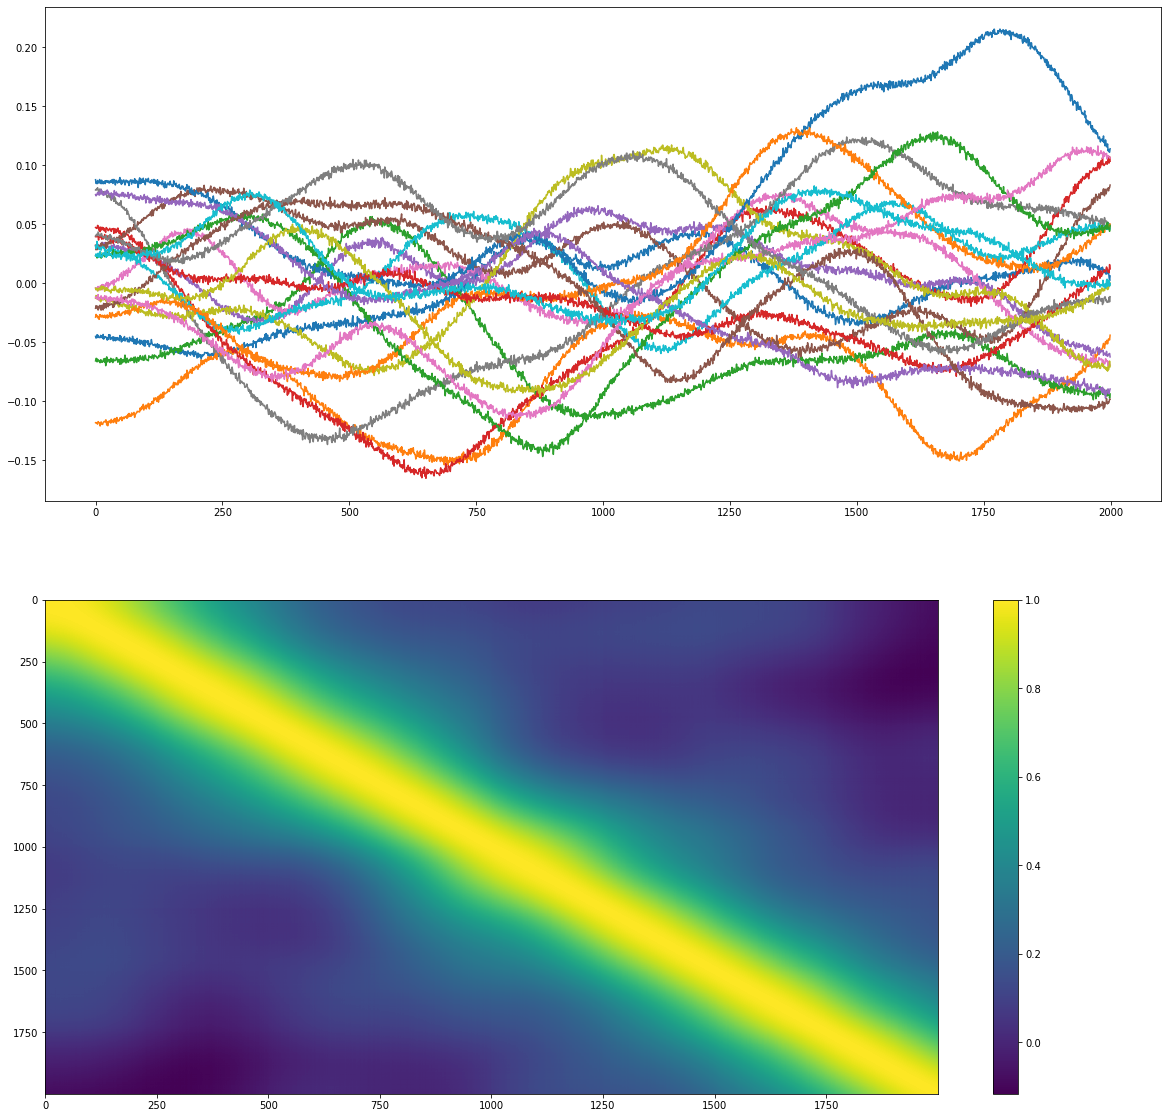

In [2]:
# create the positional encoder, with a resolution (max lag) of 500
device = 'cuda' if torch.cuda.is_available() else 'cpu'
encoder = spe.SPE(dimension=1, resolution=1000).to(device)
print(encoder.parameters())

# generate some encodings of length
p = encoder(num=256, shape=2000)

# display the first 20 of them
p = p.detach()
plt.figure(figsize=[20,20])
plt.subplot(211)
plt.plot(p[:20].cpu().T);

# compute the p.T p to display the corresponding attention matrix
plt.subplot(212)
plt.imshow(torch.mm(p.T, p).cpu().numpy(), aspect='auto')
plt.colorbar()

In [5]:
from torchvision.utils import make_grid
from itertools import product

%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest', aspect='auto')


# create the positional encoder, with a resolution (max lag) of 500
device = 'cuda' if torch.cuda.is_available() else 'cpu'
kernel_size = 100
conv_encoder = spe.ConvSPE(dimension=2, kernel_size=kernel_size).to(device)


print('conv weight shape', conv_encoder.conv.weight.shape)

# generate some encodings of length
sig_shape = [100, 100]
p = conv_encoder(num=128, shape=sig_shape)

print(p.shape)

# display the first 20 of them
p = p.detach()
plt.figure(figsize=[20,20])
plt.subplot(211)
show(make_grid(p[:12, None],nrow=3, normalize=True))

# compute the p.T p to display the corresponding attention matrix
plt.subplot(212)
pos_attentions = []
for x,y in itertools.product([0, sig_shape[0]], [0, sig_shape[1]]):
plt.imshow(torch.mm(p.T, p).cpu().numpy(), aspect='auto')
plt.colorbar()

conv weight shape torch.Size([1, 1, 127, 127])
[1020, 1020]


KeyboardInterrupt: 

In [8]:
spe.ConvSPE

spe.spe.ConvSPE